In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set()

from models.model_utility import*
from src.bluerov_torch import*

torch.manual_seed(0)
torch.set_float32_matmul_precision('high')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

In [41]:
model = torch.load("models/pinn_no_rollout_rotated_less_layers_0")
train_dataloader, dev_dataloader, _, _ = get_data_sets(1000)

C:\Users\dfels\AppData\Local\Temp\ipykernel_25404\1284446191.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/pinn_no_rollout_rotated_less_laye

tensor(1.6705e-05)


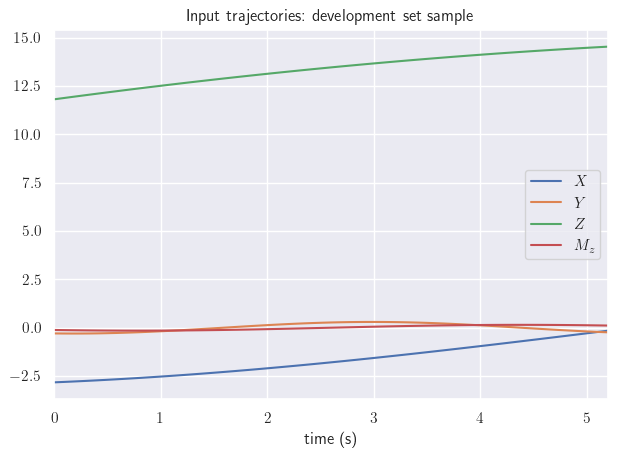

In [42]:
X_0, U_0, t_coll_0, time_0 = next(iter(dev_dataloader))
Z_coll, N_batch, N_seq, N_x = convert_input_data(X_0.to(device), U_0.to(device), time_0.to(device))
X_hat = model(Z_coll)
N_total = Z_coll.shape[0]     # Total number of samples (N_batch * N_seq)
N_in = Z_coll.shape[1]        # Number of input features
N_out = X_hat.shape[1]        # Number of outputs (states)

N_batch = X_0.shape[0]
N_x = X_0.shape[2]
N_u = U_0.shape[-1]
N_seq = X_0.shape[1]

X_hat = X_hat.view(N_batch, N_seq, N_x)
X_hat = X_hat.detach().cpu().numpy()

dt = 0.08
t = np.linspace(0, dt*N_seq, N_seq)
cos_psi = X_0[0, 1:, 3]
sin_psi = X_0[0, 1:, 4]

psi = np.arctan2(sin_psi, cos_psi)
#plt.plot(t[:-1], psi)
#plt.legend(["Psi [rad]"])

#plt.show()
plt.plot(np.arange(U_0[0, :, 0].shape[0])*time_0[0,0].numpy(), U_0[0, :, 0].cpu().detach().numpy())
plt.plot(np.arange(U_0[0, :, 1].shape[0])*time_0[0,0].numpy(), U_0[0, :, 1].cpu().detach().numpy())
plt.plot(np.arange(U_0[0, :, 2].shape[0])*time_0[0,0].numpy(), U_0[0, :, 2].cpu().detach().numpy())
plt.plot(np.arange(U_0[0, :, 3].shape[0])*time_0[0,0].numpy(), U_0[0, :, 3].cpu().detach().numpy())
plt.legend(["$X$", "$Y$", "$Z$", "$M_z$"])
plt.xlabel("time (s)")
plt.title("Input trajectories: development set sample")
plt.xlim([0, 5.2])
plt.tight_layout()
plt.savefig("input_development.pdf")
print(((X_0[:, 1:] - X_hat[:, :-1])**2).mean())

In [43]:
(100*torch.log10(rollout_loss_fn(model, X_0.to(device), U_0.to(device), time_0.to(device), 10, device, t_coll_0.to(device), False, 0.0)[0])).round()/100

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [44]:
(100*torch.log10(physics_loss_fn(model, X_0.to(device), U_0.to(device), t_coll_0.to(device), device, 0.0))).round()/100

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


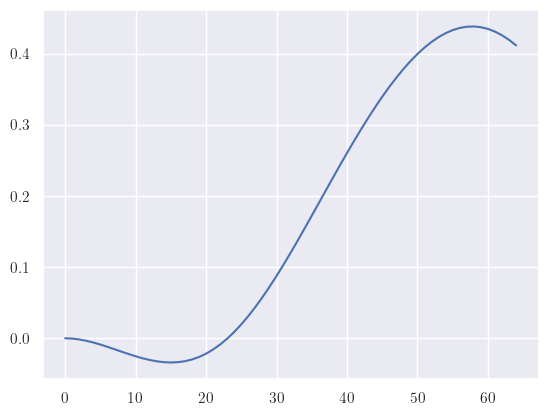

In [ ]:
plt.plot(X_0[0, :, 1].cpu().detach().numpy())

In [5]:
def rescale_ax(ax):
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    x_scale = abs(x_max - x_min)
    y_scale = abs(y_max - y_min)
    if x_scale > y_scale:
        # Calculate the new y limits to match x scale
        y_center = (y_min + y_max) / 2
        y_new_half = x_scale / 2
        ax.set_ylim([y_center - y_new_half, y_center + y_new_half])
    else:
        # Calculate the new x limits to match y scale
        x_center = (x_min + x_max) / 2
        x_new_half = y_scale / 2
        ax.set_xlim([x_center - x_new_half, x_center + x_new_half])

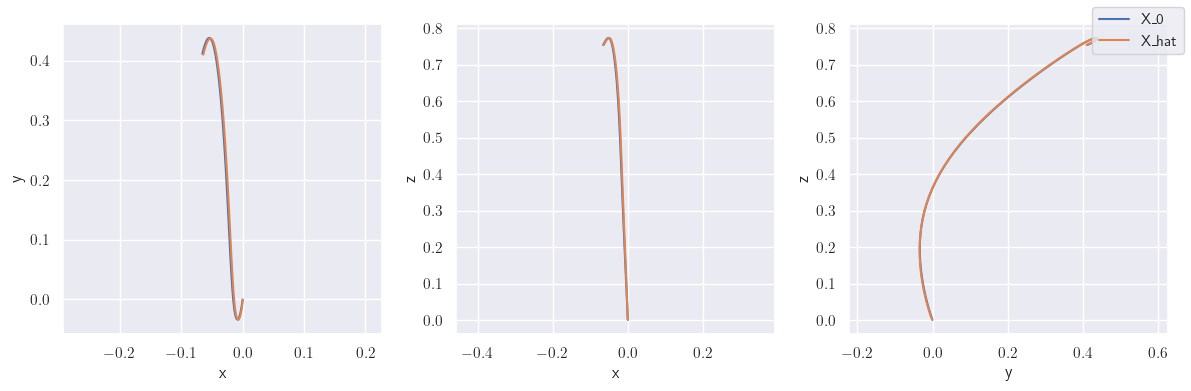

In [6]:
for i in range(1):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12,4))
    
    ax0.plot(X_0[i, 1:, 0], X_0[i, 1:, 1])
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    rescale_ax(ax0)
    ax1.plot(X_0[i, 1:, 0], X_0[i, 1:, 2])
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    rescale_ax(ax1)
    ax2.plot(X_0[i, 1:, 1], X_0[i, 1:, 2])
    ax2.set_xlabel("y")
    ax2.set_ylabel("z")
    rescale_ax(ax2)
    fig.set_tight_layout('tight=0.1')

    ax0.plot(X_hat[0, :-1, 0], X_hat[0, :-1, 1])
    ax1.plot(X_hat[0, :-1, 0], X_hat[0, :-1, 2])
    ax2.plot(X_hat[0, :-1, 1], X_hat[0, :-1, 2])

    #fig.legend(["X_0"])
    fig.legend(["X_0", "X_hat"])

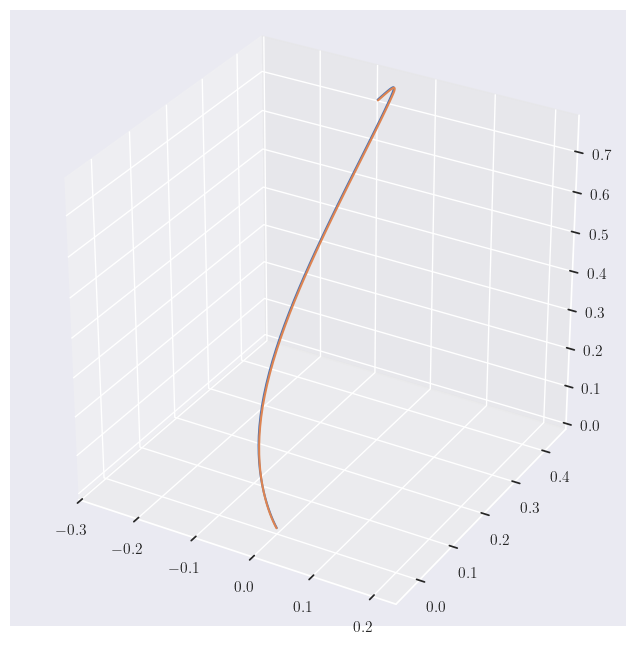

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
#ax.view_init(elev=30, azim=10, roll=0)
ax.plot(X_0[0, 1:, 0], X_0[0, 1:, 1], X_0[0, 1:, 2])
ax.plot(X_hat[0, :-1, 0], X_hat[0, :-1, 1], X_hat[0, :-1, 2])
ax.set_box_aspect([1, 1, 1])
rescale_ax(ax)

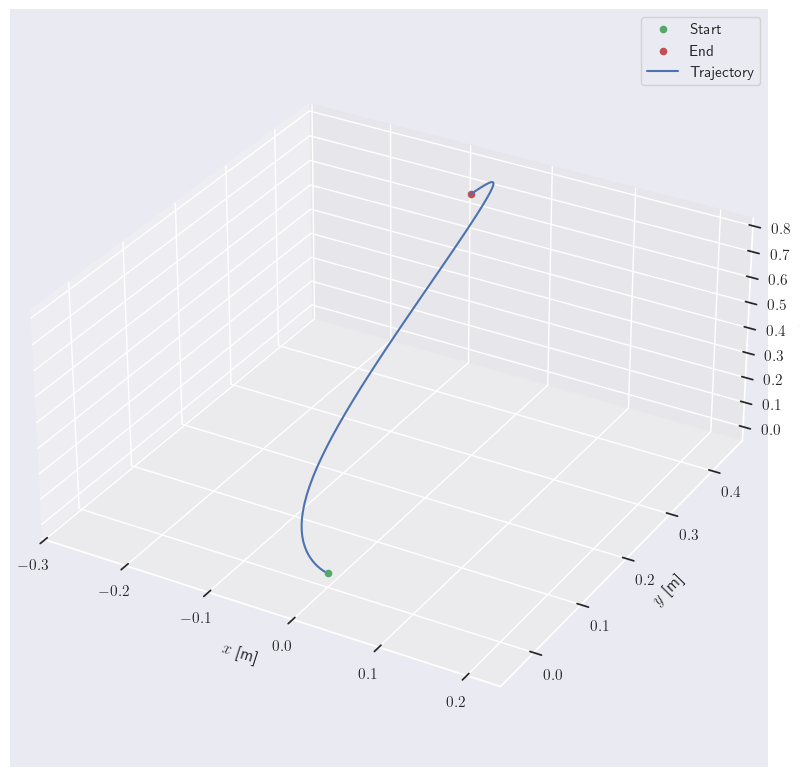

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
#ax.view_init(elev=30, azim=10, roll=0)
ax.scatter(X_0[0, 0, 0], X_0[0, 0, 1], X_0[0, 0, 2], c='g')
ax.scatter(X_0[0, -1, 0], X_0[0, -1, 1], X_0[0, -1, 2], c='r')
ax.plot(X_0[0, 0:, 0], X_0[0, 0:, 1], X_0[0, 0:, 2])
#ax.plot(X_hat[0, :-1, 0], X_hat[0, :-1, 1], X_hat[0, :-1, 2])
ax.set_box_aspect([1, 1, 0.5])
ax.legend(["Start", "End", "Trajectory"])
ax.set_xlabel("$x$ [m]")
ax.set_ylabel("$y$ [m]")
ax.set_zlabel("$z$ [m]")
rescale_ax(ax)
plt.tight_layout()
plt.savefig("trajectory.pdf")

In [5]:
plt.plot(t[:-1], (X_0[0, 1:, 0] - X_hat[0, :-1, 0])**2)
plt.plot(t[:-1], (X_0[0, 1:, 1] - X_hat[0, :-1, 1])**2)
plt.plot(t[:-1], (X_0[0, 1:, 2] - X_hat[0, :-1, 2])**2)
plt.legend(["MSE for x-predictions", "MSE for y-predictions", "MSE for z-predictions"])

NameError: name 'plt' is not defined

In [6]:
cos_psi = X_0[0, 1:, 3]
sin_psi = X_0[0, 1:, 4]
cos_psi_hat = X_hat[0, :-1, 3]
sin_psi_hat = X_hat[0, :-1, 4]

psi = np.arctan2(sin_psi, cos_psi)
psi_hat = np.arctan2(sin_psi_hat, cos_psi_hat)
plt.plot(t[:-1], (psi - psi_hat)**2)
plt.legend(["MSE for psi-predictions"])

NameError: name 'X_0' is not defined

In [7]:
plt.plot(t[:-1], (X_0[0, 1:, 5] - X_hat[0, :-1, 5])**2)
plt.plot(t[:-1], (X_0[0, 1:, 6] - X_hat[0, :-1, 6])**2)
plt.plot(t[:-1], (X_0[0, 1:, 7] - X_hat[0, :-1, 7])**2)
plt.legend(["MSE for u-predictions", "MSE for v-predictions", "MSE for w-predictions"])

NameError: name 'plt' is not defined

In [8]:
plt.plot(t[:-1], (X_0[0, 1:, 8] - X_hat[0, :-1, 8])**2)
plt.legend(["MSE for r-predictions"])

NameError: name 'plt' is not defined

In [13]:
X_hat = X_0[:, 0, :].unsqueeze(1).to(device)
X_hat.shape

torch.Size([80, 1, 9])

# Long range predictions rollout

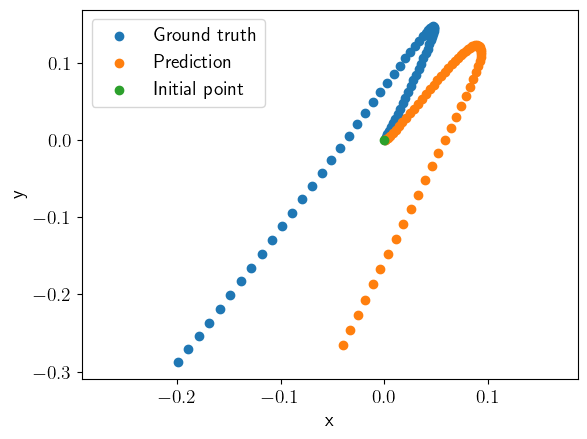

In [14]:
X_0, U_0, t_coll_0, time_0 = next(iter(dev_dataloader))
X_0_preds = torch.zeros_like(X_0).to(device)
X_hat = X_0[:, 0, :].unsqueeze(1).to(device)
    
for i in range(65):
    Z_0, N_batch, N_seq, N_x = convert_input_data(X_hat, U_0[:, i, :].unsqueeze(1).to(device), time_0[:, i, :].unsqueeze(1).to(device))
    Z_hat_0 = model(Z_0)
    X_hat = convert_output_data(Z_hat_0, N_batch, N_seq, N_x)
    X_0_preds[:, i, :] = X_hat.squeeze(1)
x = X_0[0, :, 0].cpu().detach()
y = X_0[0, :, 1].cpu().detach()
z = X_0[0, :, 2].cpu().detach()
x_hat = X_0_preds[0, :, 0].cpu().detach()
y_hat = X_0_preds[0, :, 1].cpu().detach()
z_hat = X_0_preds[0, :, 2].cpu().detach()
fig, ax = plt.subplots()
ax.scatter(x.numpy()[1:65], y.numpy()[1:65])
ax.scatter(x_hat.numpy()[:64], y_hat.numpy()[:64])
ax.scatter(x.numpy()[0], y.numpy()[0])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(["Ground truth", "Prediction", "Initial point"])
rescale_ax(ax)

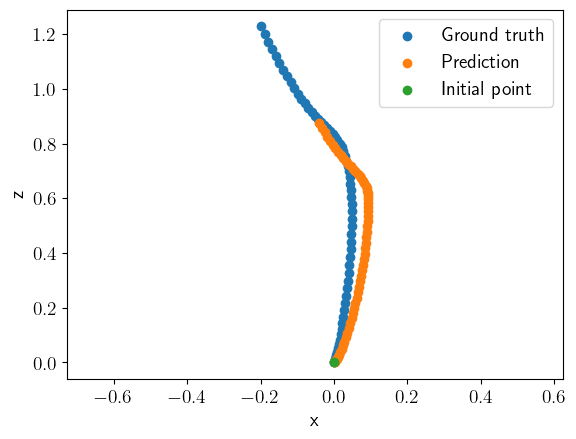

In [15]:
fig, ax = plt.subplots()
ax.scatter(x.numpy()[1:65], z.numpy()[1:65])
ax.scatter(x_hat.numpy()[:64], z_hat.numpy()[:64])
ax.scatter(x.numpy()[0], z.numpy()[0])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("x")
ax.set_ylabel("z")
rescale_ax(ax)

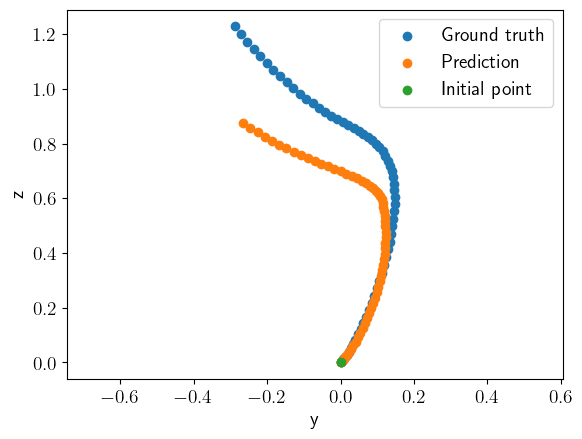

In [16]:
fig, ax = plt.subplots()
ax.scatter(y.numpy()[1:65], z.numpy()[1:65])
ax.scatter(y_hat.numpy()[:64], z_hat.numpy()[:64])
ax.scatter(y.numpy()[0], z.numpy()[0])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("y")
ax.set_ylabel("z")
rescale_ax(ax)

Text(0, 0.5, 'Psi (rad)')

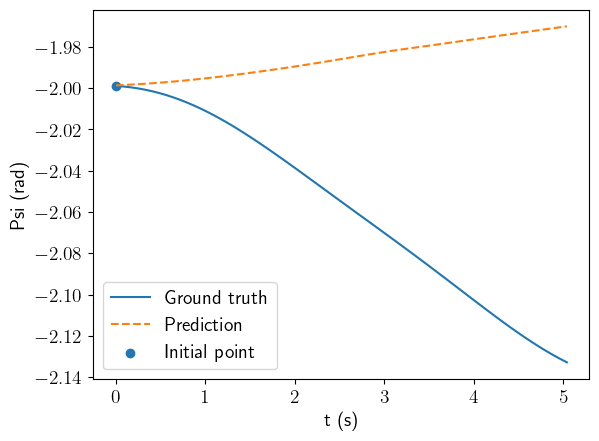

In [17]:
t = np.linspace(0, 63*0.08, 64)

cos_psi = X_0[0, :, 3].cpu().detach()
sin_psi = X_0[0, :, 4].cpu().detach()
cos_psi_hat = X_0_preds[0, :, 3].cpu().detach()
sin_psi_hat = X_0_preds[0, :, 4].cpu().detach()


psi = np.arctan2(sin_psi, cos_psi)
psi_hat = np.arctan2(sin_psi_hat, cos_psi_hat)

fig, ax = plt.subplots()
ax.plot(t, psi[1:65])
ax.plot(t, psi_hat[:64], '--')
ax.scatter(0, psi[1])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("t (s)")
ax.set_ylabel("Psi (rad)")
#rescale_ax(ax)

Text(0, 0.5, 'Angular Velocity r (m/s)')

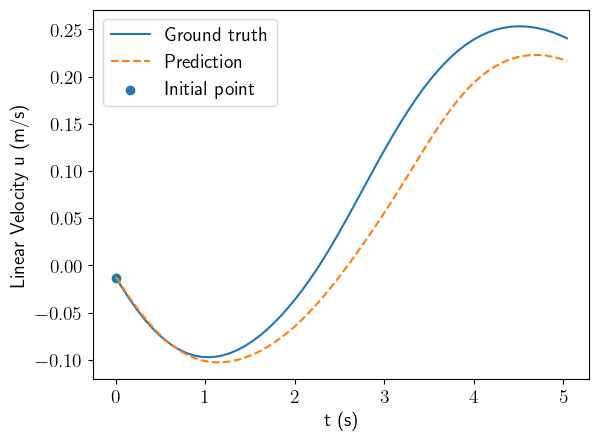

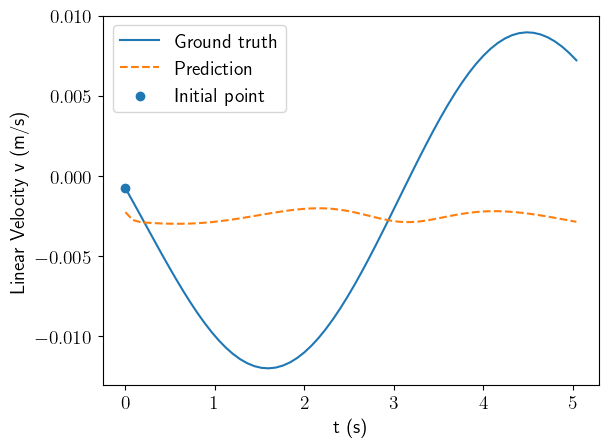

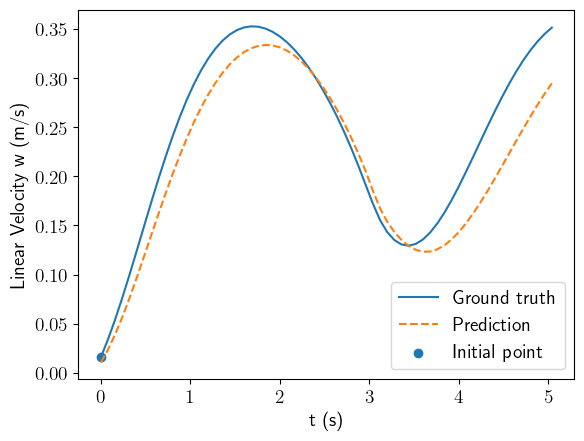

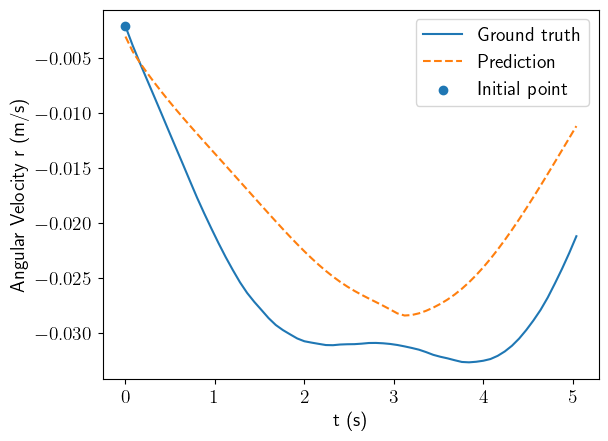

In [18]:
u = X_0[0, :, 5].cpu().detach()
v = X_0[0, :, 6].cpu().detach()
w = X_0[0, :, 7].cpu().detach()
r = X_0[0, :, 8].cpu().detach()
u_hat = X_0_preds[0, :, 5].cpu().detach()
v_hat = X_0_preds[0, :, 6].cpu().detach()
w_hat = X_0_preds[0, :, 7].cpu().detach()
r_hat = X_0_preds[0, :, 8].cpu().detach()


fig, ax = plt.subplots()
ax.plot(t, u.numpy()[1:65])
ax.plot(t, u_hat.numpy()[:64], '--')
ax.scatter(0, u.numpy()[1])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("t (s)")
ax.set_ylabel("Linear Velocity u (m/s)")

fig, ax = plt.subplots()
ax.plot(t, v.numpy()[1:65])
ax.plot(t, v_hat.numpy()[:64], '--')
ax.scatter(0, v.numpy()[1])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("t (s)")
ax.set_ylabel("Linear Velocity v (m/s)")

fig, ax = plt.subplots()
ax.plot(t, w.numpy()[1:65])
ax.plot(t, w_hat.numpy()[:64], '--')
ax.scatter(0, w.numpy()[1])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("t (s)")
ax.set_ylabel("Linear Velocity w (m/s)")

fig, ax = plt.subplots()
ax.plot(t, r.numpy()[1:65])
ax.plot(t, r_hat.numpy()[:64], '--')
ax.scatter(0, r.numpy()[1])
ax.legend(["Ground truth", "Prediction", "Initial point"])
ax.set_xlabel("t (s)")
ax.set_ylabel("Angular Velocity r (m/s)")

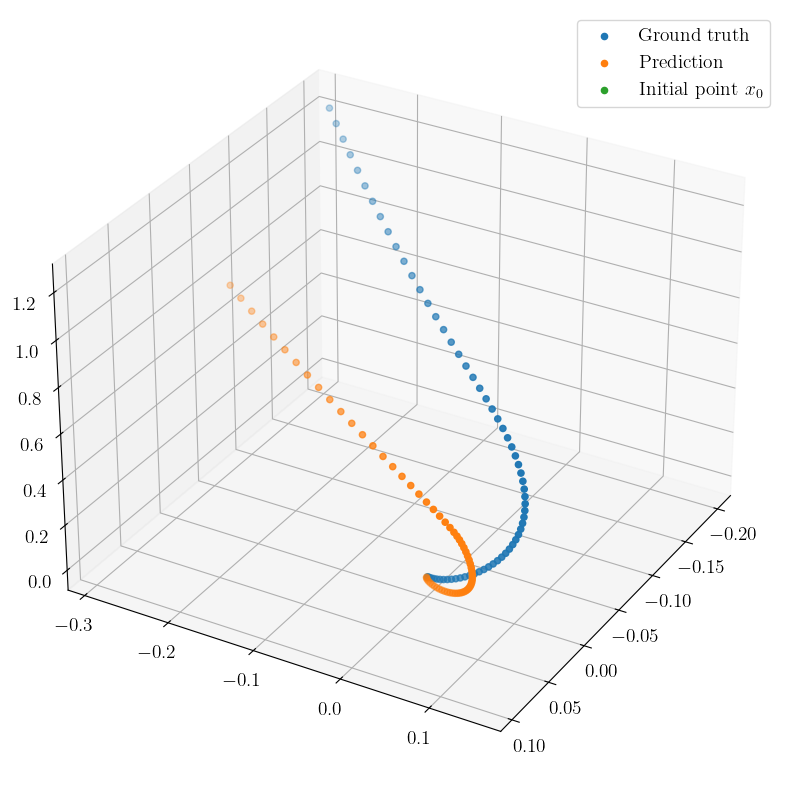

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=30, roll=0)
#ax.set_zlim(X_0[0, :, 2].max(), 0)
ax.scatter(x.numpy()[1:65], y.numpy()[1:65], z.numpy()[1:65])
ax.scatter(x_hat.numpy()[:64], y_hat.numpy()[:64], z_hat.numpy()[:64])
ax.scatter(x.numpy()[0], y.numpy()[0], z.numpy()[0])
ax.legend(["Ground truth", "Prediction", "Initial point $x_0$"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#ax.set_xlim([-0.2, 0.2])
#ax.set_ylim([-0.2, 0.2])
#rescale_ax(ax)
#ax.set_zlim([0, 0.5])

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\dfels\AppData\Local\Temp\ipykernel_11808\3467146711.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$||\mathbf{e}_{pos}||_2$")


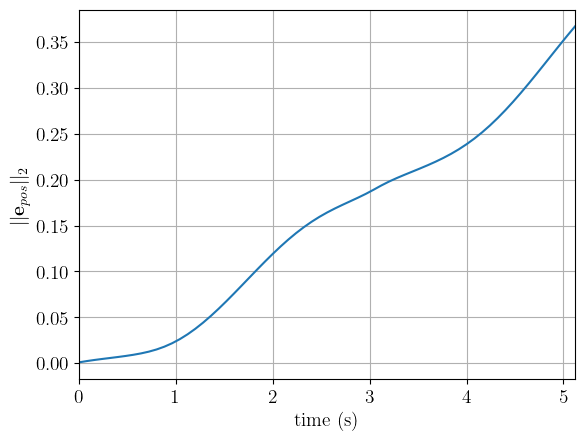

In [20]:
e_pos = ((x-x_hat)**2 + (y-y_hat)**2 + (z - z_hat)**2).sqrt()
plt.plot(0.08*np.arange(e_pos.shape[-1]), e_pos)
plt.xlabel("time (s)")
plt.ylabel("$||\mathbf{e}_{pos}||_2$")
plt.xlim([0, 5.12])
plt.grid()

In [ ]:
dt = 0.08 # change for test sets
N_batch = X_0.shape[0]
ivp_sum = 0.0
e_thr = 0.05
for n in range(N_batch):
    ivp_sum += dt*torch.nonzero(((X_0[n, 1:, 0].cpu().detach() - X_0_preds[n, :-1, 0].cpu().detach())**2 + (X_0[n, 1:, 1].cpu().detach() - X_0_preds[n, :-1, 1].cpu().detach())**2 + (X_0[n, 1:, 2].cpu().detach() - X_0_preds[n, :-1, 2].cpu().detach())**2).sqrt() <= e_thr)[-1][0]
ivp = ivp_sum/N_batch
ivp

In [21]:
for i in range(0, len(x)):
    x_hat[i] = x[0] + 0.08*u_hat[i]
    y_hat[i] = y[0] + 0.08*v_hat[i]
    z_hat[i] = z[0] + 0.08*w_hat[i]
    psi_hat[i] = r[0] +0.08*r_hat[i]

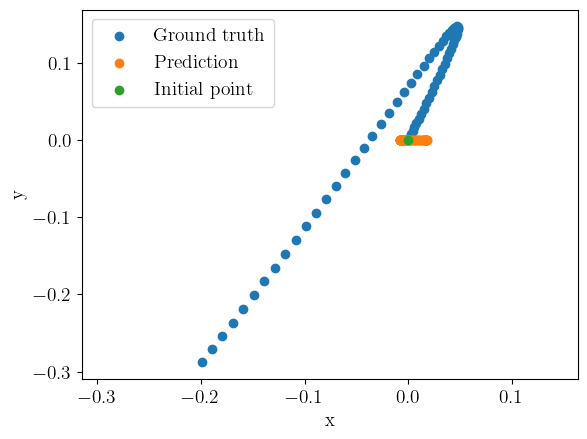

In [22]:
fig, ax = plt.subplots()
ax.scatter(x.numpy()[1:65], y.numpy()[1:65])
ax.scatter(x_hat.numpy()[:64], y_hat.numpy()[:64])
ax.scatter(x.numpy()[0], y.numpy()[0])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(["Ground truth", "Prediction", "Initial point"])
rescale_ax(ax)

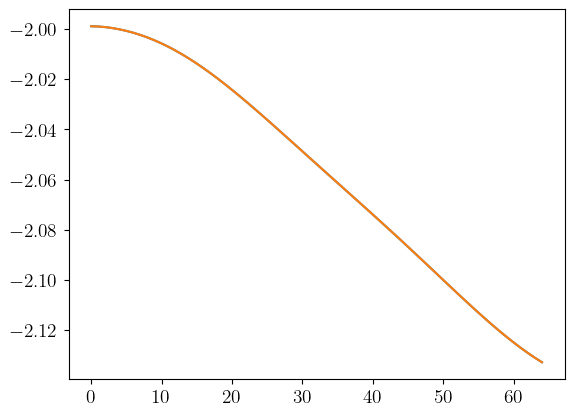

In [23]:
plt.plot(psi)
plt.plot(psi)